In [1]:
import numpy as np
def create_Phi(x):
    return np.hstack((np.ones((len(x),1)),x))        

def softmax(h):
    phat = np.exp(h)/((np.sum(np.exp(h),axis = 1)).reshape(len(h),1))
    return phat

def sigmoid(h):
    return (1/(1 + np.exp(-h)))

def crossEntropy(p,y):
    if y.shape[1] <= 1:
        return -np.sum(np.multiply(y,np.log(p))+np.multiply((1-y),np.log(1-p)))/len(p)
    else:
        return -np.sum(np.multiply(y,np.log(p)))/len(p)


In [71]:
class LogisticRegression:
    
    def __init__(self, X, Y, basis=create_Phi, cost=crossEntropy):
        if Y.shape[1] == 1:
            self.outputfunc = sigmoid
            self.target = 1
        elif Y.shape[1] == 0:
            Y = Y.reshape(len(Y),1)
            self.outputfunc = sigmoid
            self.target = 1
        elif len(np.unique(Y)) > 1:
            self.outputfunc = softmax
            self.target = Y.shape[1]
        else:
            print("Invalid Dimensions")
        self.basis = basis
        self.X = np.array(self.basis(X))
        self.Y = np.array(Y)
        self.features = self.X.shape[1]
        self.cost=cost
    
    def initializeWeights(self):
        self.weights = np.random.randn(self.features, self.target)
        self.G = np.ones_like(self.weights)
        self.V = np.zeros_like(self.weights)
        self.mov = np.zeros_like(self.weights)
        
    def adaGrad(self):
        self.G = self.G + (self.trn.T@(self.p-self.ytrn))**2
        
    def rmsProp(self, gamma):
        self.G = gamma*self.G + (1-gamma)*(self.trn.T@(self.p-self.ytrn))**2
        
    def adam(self, mu, gamma):
        self.mov = mu*self.mov + (1-mu)*self.trn.T@(self.p-self.ytrn)
        self.V = gamma*self.V + (1-gamma)*(self.trn.T@(self.p-self.ytrn))**2
        
    def updateLR(self, G):
        self.LR = self.LRo / np.sqrt(G + 1e-10)
    
    def train(self, LR=1e-6, epochs=1000, lmb1=[0], lmb2=[0], vocal=False, split=.8, reinit=True, LRupdate=None):
        data_index = np.array(range(0,len(self.X)))
        np.random.shuffle(data_index)
        sp_i = int(np.floor(len(self.X)*split))
        trn_i = data_index[0:sp_i]
        val_i = data_index[sp_i:]
        self.trn = np.take(self.X, trn_i, axis=0)
        self.ytrn = np.take(self.Y, trn_i, axis=0)
        self.val = np.take(self.X, val_i, axis=0)
        self.yval = np.take(self.Y, val_i, axis=0)
        self.LRo = LR
        self.LR = LR
        self.errors = []
        if reinit==True:
            self.initializeWeights()
        CE_best = np.inf
        for lm1 in lmb1:
            for lm2 in lmb2:
                if reinit==True:
                    self.initializeWeights()
                for ep in range(epochs):
                    self.p = self.outputfunc(self.trn@self.weights)
                    if LRupdate == 'adagrad':
                        self.adaGrad()
                        self.updateLR(self.G)
                    elif LRupdate == 'rmsprop':
                        self.rmsProp(gamma=.9)
                        self.updateLR(self.G)
                    elif LRupdate == 'adam':
                        self.adam(mu=.9,gamma=.9)
                        self.updateLR(self.V)
                    self.weights -= self.LR * self.trn.T@(self.p-self.ytrn) + lm1*np.sign(self.weights) + lm2*self.weights
                    phat = self.outputfunc(self.val@self.weights)
                    CE = self.cost(phat,self.yval)
                    self.errors.append([lmb1, lmb2, ep, CE])
                    if np.isnan(CE):
                        break
                    if vocal == True:
                        print("Lambda 1 / Lambda 2 / Epoch / Error = {}".format(self.errors[-1]))
                    if CE > CE_best:
                        CE_best = CE
                        self.parameters = [lmb1, lmb2]
                        self.w_best = self.weights
        
                              
    def predict(self, test):
        self.predictions = self.outputfunc(self.basis(test)@self.w_best)
        #self.prediction = (self.probabilities == self.probabilities.max(axis=1)[:,None]).astype(int)          

In [3]:
import matplotlib.pyplot as plt
#Min-max scaling
def normalizeMM(x,xtrn):
    newx = ((x - xtrn.min(0))/(xtrn.max(0)-xtrn.min(0)))
    return newx
    
def radius(x,r1,r2):
    delete = []
    for i in range(np.size(x,0)):
        if (np.sqrt(x[i,0]**2 + x[i,1]**2) < r1) | (r2 < np.sqrt(x[i,0]**2 + x[i,1]**2)):
            delete.append(i)
    xnew = np.delete(x, delete, 0)
    return xnew

def oneHotEncode(x):
    x = np.array(x)
    unique = np.unique(x)
    newx = np.zeros((x.shape[0], len(unique)))
    for i in range(x.shape[0]):
        for j in range(len(unique)):
            if x[i] == unique[j]:
                newx[i,j] = 1
    return newx

def accuracy(p,y):
    if p.shape[1] == 1:
        yhat = np.rint(p)
    elif p.shape[1] > 1:
        yhat = (p == p.max(axis=1)[:,None]).astype(int)
    return np.mean(yhat == y)

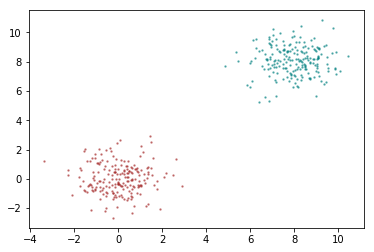

In [76]:
N = 200
x0 = np.random.randn(N,2)+8
lab0 = np.zeros((N,1))
x1 = np.random.randn(N,2)
lab1 = np.ones((N,1))
X = np.vstack((x0,x1))
Y = np.vstack((lab0,lab1))
X = normalizeMM(X,X)
plt.scatter(x0[:,0],x0[:,1], s=2, alpha=.5, c="teal")
plt.scatter(x1[:,0],x1[:,1], s=2, alpha=.5, c="brown")
plt.show()

In [80]:
LRrms = LogisticRegression(X,Y, cost=accuracy)

In [90]:
LRrms.train(LR=1e-2, epochs=100, vocal=True, LRupdate=None)

Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 0, 0.4875]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 1, 0.5]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 2, 0.8125]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 3, 0.9875]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 4, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 5, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 6, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 7, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 8, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 9, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 10, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 11, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 12, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 13, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 14, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 15, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 16, 1.0]
Lambda 1 / Lamb

In [88]:
LRrms.train(LR=1e-2, epochs=100, vocal=True, LRupdate='adagrad')

Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 0, 0.55]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 1, 0.55]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 2, 0.55]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 3, 0.55]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 4, 0.55]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 5, 0.575]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 6, 0.625]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 7, 0.7875]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 8, 0.9]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 9, 0.9875]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 10, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 11, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 12, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 13, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 14, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 15, 1.0]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 16, 1.0]
Lambda 1 

In [89]:
LRrms.train(LR=1e-2, epochs=100, vocal=True, LRupdate='rmsprop')

Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 0, 0.3125]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 1, 0.325]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 2, 0.35]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 3, 0.3875]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 4, 0.4]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 5, 0.425]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 6, 0.4375]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 7, 0.4625]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 8, 0.4625]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 9, 0.4875]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 10, 0.525]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 11, 0.55]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 12, 0.55]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 13, 0.5625]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 14, 0.575]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0], 15, 0.5875]
Lambda 1 / Lambda 2 / Epoch / Error = [[0], [0]